In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, RobustScaler, StandardScaler
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from  sklearn import svm
import warnings
warnings.filterwarnings('ignore')
acident_index_train=[31,35,36,45,50,52,55,56,60,67,68,69,76,78,84,90,91,92,94,95,96,98,100,102,103,106,109,116,117,120,121,123,128,129,130,131,132,133,136,138,145,147,148,151,152,153,154,155,159,161]
acident_index_test=[162,166,170,171,173,174,176,177,180,181,184,187,188,189,190,193,197,198,199,201,202,204,205,212,213,216,218,219,220,221,226,231,233,236,240,241,242,243,244,252]
trafic_data=pd.read_parquet("traffic_data.parquet")
incident=pd.read_csv("incidents.csv")
trafic_data["timestamp"] = pd.to_datetime(trafic_data["timestamp"])
incident["timestamp"] = pd.to_datetime(incident["timestamp"])
pd.set_option('display.max_columns', None)
incident

,Unnamed: 0,incident_id,cc_code,timestamp,description,latitude,longitude,district,freeway_nmbr,freeway_direction,state_postmile,abs_postmile,duration,up_id,up_lanes,up_distance,up_latitude,up_longitude,down_id,down_lanes,down_distance,down_latitude,down_longitude,active_onramp,active_offramp
0,0,16175990,SAHB,2016-01-01 16:30:00,1179-Trfc Collision-1141 Enrt,38.280275,-121.456931,3.0,5,N,NaN,497.1,70.0,317393,2,-1.607,38.257363,-121.448669,319227,2,0.101,38.281219,-121.457043,False,False
1,1,16177033,SAHB,2016-01-02 13:25:00,1183-Trfc Collision-Unkn Inj,39.314110,-120.447967,3.0,80,W,NaN,170.6,60.0,317798,2,3.203,39.325458,-120.392564,319430,2,-5.605,39.310097,-120.544000,True,True
2,2,16177599,SAHB,2016-01-02 19:00:00,1182-Trfc Collision-No Inj,38.603209,-121.435469,3.0,51,S,NaN,4.0,40.0,318540,4,0.196,38.605475,-121.433198,314157,4,-0.271,38.600753,-121.438775,True,True
3,3,16182414,SAHB,2016-01-08 07:45:00,1179-Trfc Collision-1141 Enrt,38.343525,-121.335578,3.0,99,N,NaN,281.8,45.0,317652,2,-0.730,38.333162,-121.330741,317660,2,0.730,38.352842,-121.340605,False,False
4,4,16183558,SAHB,2016-01-08 17:10:00,1182-Trfc Collision-No Inj,38.560374,-121.481408,3.0,50,E,NaN,5.2,80.0,312139,5,-0.477,38.562532,-121.489560,318282,4,0.122,38.559773,-121.479137,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,447,16907027,SAHB,2016-12-26 13:05:00,1179-Trfc Collision-1141 Enrt,38.758050,-121.261450,3.0,80,E,3.087,104.6,65.0,318801,4,-0.126,38.756912,-121.262242,318844,4,0.070,38.759443,-121.260582,False,False
448,448,16908065,SAHB,2016-12-27 05:50:00,1179-Trfc Collision-1141 Enrt,38.249222,-121.290476,3.0,99,S,0.355,274.8,50.0,319100,2,0.350,38.253209,-121.292972,317640,2,-0.134,38.246918,-121.288935,False,False
449,449,16908856,SAHB,2016-12-27 14:15:00,1179-Trfc Collision-1141 Enrt,38.651912,-121.370190,3.0,80,W,R11.462,95.1,50.0,313368,6,0.200,38.653680,-121.368403,314165,2,-0.895,38.645422,-121.384400,False,False
450,450,16911088,SAHB,2016-12-28 18:05:00,1183-Trfc Collision-Unkn Inj,38.596708,-121.549171,3.0,80,W,R11.6,83.8,75.0,319142,3,0.477,38.603117,-121.544779,317885,3,-0.613,38.589094,-121.554290,False,False


In [16]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
def Isolation_Forest(x):
    train=pd.DataFrame()
    result = trafic_data[(trafic_data['station_id'] == incident.at[x,'up_id'])&(trafic_data['timestamp'] <= incident.at[x,'timestamp'] + timedelta(hours=6))&(trafic_data['timestamp'] >= incident.at[x,'timestamp'] + timedelta(hours=-6))]
    result['current']=0
    result.loc[(result['timestamp'] >= incident.at[x,'timestamp'])&(result['timestamp'] <= incident.at[x,'timestamp']+ timedelta(minutes=incident.at[x,'duration'])), 'current'] = 1
    train = pd.concat([train, result], axis=0)
    train["timestamp"] = pd.to_datetime(train["timestamp"])
    scaler = StandardScaler()
    scaler.fit(train[["speed"]])
    train[["speed"]] = scaler.fit_transform(train[["speed"]])
    train[["occ"]] = scaler.fit_transform(train[["occ"]])
    train[["flow"]] = scaler.fit_transform(train[["flow"]])
    model=OneClassSVM(nu=0.1)
    model.fit(train[["speed","occ","flow"]])
    train['scores']=model.decision_function(train[["speed","occ","flow"]])
    train['anomaly']=model.predict(train[["speed","occ","flow"]])

    return(train)


result=Isolation_Forest(188)

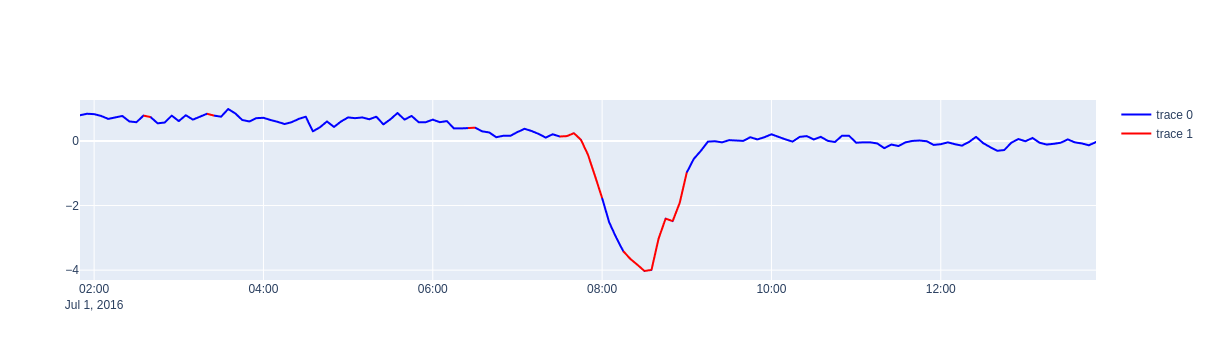

In [17]:
fig = go.Figure()
fig.add_scattergl(x=result["timestamp"], y=result["speed"], line={'color': 'blue'})
fig.add_scattergl(x = result["timestamp"], y = result["speed"].where(result["anomaly"] == -1), line ={'color' : 'red'})
fig.show()

## dr score

In [18]:
def dr_score(list):
    No_of_congestions_detected=0
    No_of_true_congestions=len(list)
    for x in list:
        result=Isolation_Forest(x)
        if result.query('-1== anomaly and 1 ==current').shape[0]>1:
            No_of_congestions_detected+=1
    return(No_of_congestions_detected/No_of_true_congestions)
            
print(dr_score(acident_index_test))  

1.0


## far score

In [19]:
def far(list):
    No_of_false_alarms_signals=0
    No_of_non_congestion_instances=0
    for x in list:
        result=Isolation_Forest(x)
        No_of_non_congestion_instances+=result.query('0 ==current').shape[0]
        if result.query('-1== anomaly  and 0 ==current').shape[0]>1:
            No_of_false_alarms_signals+=result.query('-1== anomaly and 0 ==current').shape[0]
    return(No_of_false_alarms_signals/No_of_non_congestion_instances)
            
print(far(acident_index_test))

0.1433389544688027


## MTTD score

In [20]:
def MTTD(list):
    No_of_congestions_detected=0
    sum_of_time=0
    for x in list:
        result=Isolation_Forest(x)
        if result.query('-1== anomaly  and 1 ==current').shape[0]>1:
            sum_of_time+=(result[(result.anomaly == -1) &(result.current == 1)].iloc[0]["timestamp"]-incident.at[x,'timestamp']).total_seconds() / 60
            No_of_congestions_detected+=1
    return(sum_of_time/No_of_congestions_detected)        
print(MTTD(acident_index_test))

0.25
